# Create and Train the model

## Download, Imports, and Config

Make sure to run the correct PyTorch install command such as

```conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia```

in your conda environment before running this notebook.

This command can be found from the official PyTorch website: https://pytorch.org/get-started/locally/

Imports

In [1]:
# Custom imports
import sys
sys.path.insert(1, "../libs")
from postgres_data import load_postgresql_data

# General imports
import os
import random
import time
import datetime
import gc

# ML imports
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

Config

In [2]:
SEED = 777
VALIDATION_RATIO = 0.2 # 20% of training data will be used for validation

MODEL_TYPE = "bert-base-multilingual-uncased"
L_RATE = 1e-5
MAX_LEN = 80
NUM_EPOCHS = 3
BATCH_SIZE = 16 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
NUM_CORES = 0 # os.cpu_count()

torch.manual_seed(SEED)

CSV_DATA_DIR = '../1_CSV_Data'
MODELS_DIR = "./models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

# Check for GPU to speed up training
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
else:
    # device = torch.device("cpu")
    raise Exception("No GPU available, please setup GPU with CUDA before running this notebook")

# Note: For TPU
# device = xm.xla_device()

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## Loading Data and Preprocessing

Load Data

In [3]:
# create train and test dataframes
train_df_presplit, test_df = load_postgresql_data()

Preprocessing

In [4]:
#train_test_split to create validation set
train_df, val_df = train_test_split(train_df_presplit, random_state=SEED, test_size=VALIDATION_RATIO)
train_df.reset_index(drop=True, inplace=True) # reset indecies, otherwise indecies would be retained from original df
val_df.reset_index(drop=True, inplace=True)
print("Train data size: ", train_df.size)
print("Validation data size: ", val_df.size)

Train data size:  58176
Validation data size:  14544


## Define Model and Training

### Setup Datasets to use BERT's encoding, and DataLoaders for each Dataset

In [5]:
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)
len(tokenizer.vocab)

105879

To encode a sentence with BERT, we are required to:

  -  Add special tokens to the start and end of each sentence.
  -  Pad & truncate all sentences to a single constant length.
  -  Explicitly differentiate real tokens from padding tokens with the "attention mask".


In [6]:
def encode_sentence_pair(sentence1, sentence2):
    """
    Encode a sentence pair using BERT tokenizer and return the encoded array
    """
    encoded_dict = tokenizer.encode_plus(
        sentence1, sentence2,           # Sentences to encode.
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad or truncate.
        padding = "max_length",
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = "pt",          # Return pytorch tensors.
        truncation = True
    )

    # These are torch tensors
    padded_token_list = encoded_dict["input_ids"][0]
    att_mask = encoded_dict["attention_mask"][0]
    token_type_ids = encoded_dict["token_type_ids"][0]

    return (padded_token_list, att_mask, token_type_ids)

In [7]:
class LabelledDataset(Dataset):

    def __init__(self, df):        
        self.df_data = df


    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence1 = self.df_data.loc[index, "premise"]
        sentence2 = self.df_data.loc[index, "hypothesis"]

        # Encode the sentences
        padded_token_list, att_mask, token_type_ids = encode_sentence_pair(sentence1, sentence2)
        
        # Convert the target to a torch tensor
        target = torch.tensor(self.df_data.loc[index, "label"])

        sample = (padded_token_list, att_mask, token_type_ids, target)        

        return sample


    def __len__(self):
        return len(self.df_data)

In [8]:
class TestDataset(Dataset):

    def __init__(self, df):
        self.df_data = df


    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence1 = self.df_data.loc[index, "premise"]
        sentence2 = self.df_data.loc[index, "hypothesis"]

        # Encode the sentences
        padded_token_list, att_mask, token_type_ids = encode_sentence_pair(sentence1, sentence2)               

        sample = (padded_token_list, att_mask, token_type_ids)

        return sample


    def __len__(self):
        return len(self.df_data)

In [9]:
train_data = LabelledDataset(train_df)
val_data = LabelledDataset(val_df)
test_data = TestDataset(test_df)

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True # Speeds up data transfer from CPU to GPU
)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True
)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

606
152
325


In [10]:
# testing out our dataloader to ensure correct output of 1 batch
train_iter = iter(train_dataloader)
padded_token_list, att_mask, token_type_ids, target = next(train_iter)

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


### Model Definition

In [11]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 3, # The number of output labels--In our case 3
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)
model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
# Print information about the model

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer ====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Quick test of the model outputs

In [13]:
batch = next(train_iter)

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)

In [14]:
outputs = model(
    b_input_ids, 
    token_type_ids=b_token_type_ids, 
    attention_mask=b_input_mask,
    labels=b_labels
)

In [15]:
outputs

SequenceClassifierOutput(loss=tensor(1.1641, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.8905,  0.5045, -0.1344],
        [ 1.3952,  0.4899, -0.3179],
        [ 0.3276,  0.2253, -0.0970],
        [ 1.2055,  0.4207, -0.1915],
        [ 0.0345,  0.0413, -0.0766],
        [ 0.5743,  0.2739, -0.1787],
        [ 0.6232,  0.2485, -0.1518],
        [ 0.3149,  0.1726, -0.0786],
        [ 0.7125,  0.3588, -0.1735],
        [ 0.9392,  0.7605, -0.0641],
        [ 0.8242,  0.4218, -0.2156],
        [ 0.7595,  0.5397,  0.0058],
        [ 1.2743,  0.4398, -0.1960],
        [ 1.0467,  0.5713, -0.0704],
        [ 0.7264,  0.5651, -0.1569],
        [ 1.2683,  0.7980, -0.2768]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [16]:
# Get the predictions for each training example in the batch.
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [17]:
# This is the accuracy without any fine tuning based on the first batch of the training set.
val_acc = accuracy_score(y_true, y_pred)
val_acc

0.4375

Optimizer and Scheduler

In [18]:
optimizer = AdamW(model.parameters(), lr=L_RATE, eps = 1e-8) # eps is added to avoid nan (term that is added to the denominator)

In [19]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * NUM_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

### Training

Initialization

In [20]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Store the average loss and validation accuracy after each epoch so we can plot them.
loss_values = []
accuracy_values = []
val_loss_values = []
val_accuracy_values = []

Helper Functions

In [21]:
def flat_accuracy(preds, labels):
    '''
    Function to calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training loop:

 *   Unpack our data inputs and labels
 *   Load data onto the GPU for acceleration
 *   Clear out the gradients calculated in the previous pass.
     *   In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
 *   Forward pass (feed input data through the network)
 *   Backward pass (backpropagation)
 *   Tell the network to update parameters with optimizer.step()
 *   Track variables for monitoring progress

 Evalution loop:

 *   Unpack our data inputs and labels
 *   Load data onto the GPU for acceleration
 *   Forward pass (feed input data through the network)
 *   Compute loss on our validation data and track variables for monitoring progress

In [23]:
# Disable warning
import transformers
transformers.logging.set_verbosity_error()

# import logging
# logging.disable(logging.WARNING)

%%time

for epoch in range(0, NUM_EPOCHS):

    # ========================================
    #               Training
    # ========================================
          
    print("")
    print("======== Epoch {:} / {:} ========".format(epoch + 1, NUM_EPOCHS))
    print("Training...")

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss, total_accuracy = 0, 0

    # Put the model into training mode.
    model.train()

    # torch.backends.cudnn.benchmark = True

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
            
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.    Loss: {:0.2f}.    Accuracy: {:0.2f}".format(
                step, 
                len(train_dataloader), 
                elapsed, 
                sum(loss_values[-40:])/40, 
                sum(accuracy_values[-40:])/40)
            )

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Clear out the gradients (by default they accumulate)
        model.zero_grad()

        # Perform a forward pass.
        outputs = model(
            b_input_ids,
            token_type_ids=b_token_type_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs[0]
        logits = outputs[1]

        # Move to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate accuracy
        batch_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the training loss and accuracy over all of the batches so we can get the average at the end
        total_loss += loss.item() 
        total_accuracy += batch_accuracy

        # Store the loss and accuracy value for plotting the learning curve.
        loss_values.append(loss.item())
        accuracy_values.append(batch_accuracy)

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Take a step and update parameters based on the computed gradient.
        optimizer.step()

        # Scheduler updates the learning rate over time.
        scheduler.step()

    # Finished training this epoch.
    # Calculate average loss over all of the batches.
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Final training loss: {0:.2f}".format(loss_values[-1]))
    print("  Final training accuracy: {0:.2f}".format(accuracy_values[-1]))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss, total_eval_accuracy = 0, 0
    num_eval_steps = 0

    # For each batch of validation data...
    for batch in val_dataloader:

        # Unpack batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during evaluation
        with torch.no_grad():
            outputs = model( # Logits are the model outputs prior to applying an activation function such as softmax.
                b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs[0]
        logits = outputs[1]

        # Move to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate the accuracy for this batch of test sentences.
        batch_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumlate loss and accuracy.
        total_eval_loss += loss.item()
        total_eval_accuracy += batch_eval_accuracy

        num_eval_steps += 1

    # Calculate the average loss and accuracy over all batches, and store for plotting.
    eval_loss = total_eval_loss / num_eval_steps
    eval_accuracy = total_eval_accuracy / num_eval_steps

    # Store the loss and accuracy value for plotting the learning curve. We only need to do this once per epoch in validation.
    val_loss_values.append(eval_loss)
    val_accuracy_values.append(eval_accuracy)

    # Print accuracy over all batches
    print("  Loss: {0:.2f}".format(eval_loss))
    print("  Accuracy: {0:.2f}".format(eval_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Save the model checkpoint    
    torch.save(model.state_dict(), '{}/model_checkpoint_{:}_{}ep_{:0.0f}acc.pt'.format(MODELS_DIR, time.strftime("%Y%m%d-%H%M"), epoch+1, eval_accuracy*100))

    # Use the garbage collector to save memory.
    gc.collect()

print("")
print("Training complete!")

In [24]:
# Cleanup memory from run
gc.collect()

0

## Visualize and Evaluting the Model

In [25]:
# Smooth the graph a little by averaging the values in groups of k size
k = 25
smooth_loss_values = [sum(loss_values[(i*k):(i*k)+k]) / float(k) for i in range(0, int(len(loss_values) / k))]
print(smooth_loss_values)
smooth_loss_values_x = [(i * k) + int(k / 2) for i in range(0, (int(len(loss_values) / k)))]
print(smooth_loss_values_x)

[]
[]


In [26]:
# Setup Validation Loss
val_loss_values_x = [i * int(len(loss_values) / NUM_EPOCHS) for i in range(1, NUM_EPOCHS + 1)]
print(val_loss_values_x)
print(val_loss_values)

[0, 0, 0]
[]


ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

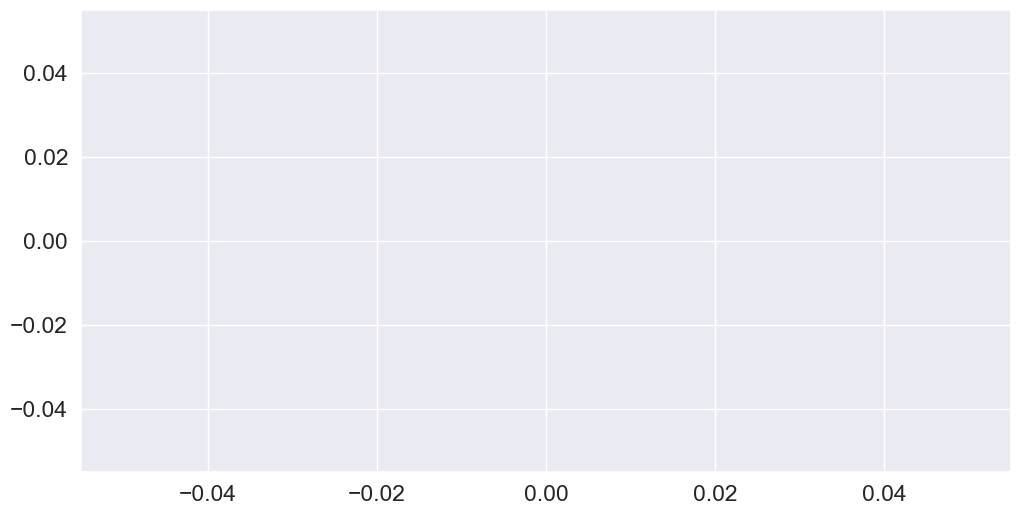

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
# plt.plot(loss_values, 'b-o')
plt.plot(smooth_loss_values_x, smooth_loss_values, 'r-o')
plt.plot(val_loss_values_x, val_loss_values, 'g-o')

# Label the plot.
plt.title("Training loss (Red) vs Validation loss (Green)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.show()

## Make predictions

In [28]:
### Reload model from disk
# Load model from checkpoint
path_model = f'{MODELS_DIR}/model_checkpoint_20230827-2223_2ep_62acc.pt'#'models/model_checkpoint_20230827-2225_3ep_63acc.pt'
model.load_state_dict(torch.load(path_model))

# Send the model to the device
model.to(device)

# Put the model in evaluation mode
model.eval()

# Turn off the gradient calculations
# This tells the model not to compute or store gradients
# This step saves memory and speeds up validation
torch.set_grad_enabled(False)

In [29]:
# Final stacked labels list
stacked_val_labels = []

# Reset the total loss for this epoch.
total_val_loss = 0

for j, h_batch in enumerate(test_dataloader):

    inference_status = 'Batch ' + str(j + 1)

    print(inference_status, end='\r')

    b_input_ids = h_batch[0].to(device)
    b_input_mask = h_batch[1].to(device)
    b_token_type_ids = h_batch[2].to(device)     


    outputs = model(b_input_ids, 
            token_type_ids=b_token_type_ids, 
            attention_mask=b_input_mask)


    # Get the preds
    preds = outputs[0]


    # Move preds to the CPU
    val_preds = preds.detach().cpu().numpy()
    
    
    # Stack the predictions.

    if j == 0:  # first batch
        stacked_val_preds = val_preds

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

In [30]:
stacked_val_preds

array([[-0.17804407,  0.36460358,  0.04536536],
       [ 1.8994677 , -0.10736712, -0.46736047],
       [ 2.2650545 , -0.09548439, -0.58953667],
       ...,
       [ 0.31025118,  0.02071255,  0.18279883],
       [-1.0606146 ,  0.16822244,  0.35274532],
       [-1.528332  ,  0.76194555, -0.10589468]], dtype=float32)

In [31]:
test_preds = np.argmax(stacked_val_preds, axis=1)
test_preds

array([1, 0, 0, ..., 0, 2, 1], dtype=int64)

## Create Kaggle submission file

In [32]:
# Load the sample submission.
# The row order in the test set and the sample submission is the same.

path = f'{CSV_DATA_DIR}/sample_submission.csv'

df_sample = pd.read_csv(path)

print(df_sample.shape)

df_sample.head()

(5195, 2)


,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


In [33]:
# Assign the preds to the prediction column

df_sample['prediction'] = test_preds

df_sample.head()

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,0
2,e98005252c,0
3,58518c10ba,2
4,c32b0d16df,2


In [34]:
# Number to label list
label_list = ['entailment', 'neutral', 'contradiction']

# Sanity check of some english entries compared to their predictions
only_en_df = test_df[test_df.lang_abv == 'en']
only_en_df = only_en_df.set_index('id')
# print(only_en_df)
only_en_df['prediction'] = only_en_df.rename(index=df_sample.set_index('id')['prediction']).index
only_en_df['prediction'] = only_en_df['prediction'].map(lambda x: label_list[x])

for i in range(10,15):
    print("Premise: {}\nHypothesis: {}\nPrediction: {}\n".format(only_en_df.iloc[i]['premise'], only_en_df.iloc[i]['hypothesis'],only_en_df.iloc[i]['prediction']))

Premise: So let me draw a slightly different moral from the saga of beach volleyball as it has evolved in our  If, as Speaker Gingrich says, the price of volleyball is eternal freedom, still it may take a village to raise a volleyball net.
Hypothesis: If a village is to be free, Speaker Gingrich believes they should not have a volleyball net. 
Prediction: contradiction

Premise: His proud reserve--a product of 40 years in the spotlight--is refreshing but does not bode well for his capacity to shepherd big ideas through Congress.
Hypothesis: He is way too loud.
Prediction: neutral

Premise: Nash showed up for an MIT New Year's Eve party clad only in a diaper.
Hypothesis: Nash had too many nasty pictures on Instagram.
Prediction: entailment

Premise: you know our church each year has a one of their major fund raisers is you know a garage sale and there's a ton of clothes always you know left over and i take those down to the uh
Hypothesis: Our church also has bake sales each year. 
Predi

In [35]:
# Create a submission csv file
df_sample.to_csv('submission.csv', index=False)